Word2vec package download and testing

In [ ]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

vec_king = wv['king']
print(vec_king.shape)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
(300,)


<span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Dataset Download and Upload in the Colab </h1></span>

For downloading and importing the dataset in you colab please follow the following steps:

*   Go to https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
*   Download the dataset. It will be downloaded as **archive.zip** in your pc
*   Upload the dataset by running the following code cells




In [ ]:
from google.colab import files
# Download the dataset. It will be downloaded as archive.zip in your pc
# Up

# Prompt user to upload a folder
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [ ]:
!unzip /content/archive.zip -d .

Archive:  /content/archive.zip
  inflating: ./test.txt              
  inflating: ./train.txt             
  inflating: ./val.txt               


<span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Emotion Recognition using LSTM </h1></span>

Emotion recognition is a task in affective computing that involves identifying and categorizing human emotions based on various inputs, such as speech, text, image, or video. Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) that can be used for emotion recognition tasks due to its ability to capture long-term dependencies in sequential data.

In [ ]:
import os, sys, random, time, datetime, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Configuration File </h1></span>

It is very similar to yaml file. We are using a config class instead of yaml file. In the config file, we are setting all the hyperparameters and essential variable assignment

In [ ]:
# Hyper parameters etc.
class CFG:
    debug = True
    n_epochs = 30
    learning_rate = 1.0e-3
    batch_size = 64
    target_cols = ['label'] # target columns
    seed = 42

    # Model parameters
    vocab_size = 2486
    embedding_dim = 300
    hidden_dim = 128
    dropout_rate = 0.25
    lstm_dropout_rate = 0.2,
    num_lstm_layers = 1
    num_class = None

In [ ]:
# Set random seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Dataset Loading </h1></span>

Let's load the dataset and see the category distribution of the dataset.

In [ ]:
# ====================================================
# Data Loading
# ====================================================

train = pd.read_csv('/content/train.txt', names=['text', 'emotion'], sep=';')
valid = pd.read_csv('/content/val.txt', names=['text', 'emotion'], sep=';')
test = pd.read_csv('/content/test.txt', names=['text', 'emotion'], sep=';')


print(f"train.shape: {train.shape}")
display(train.head())

print(f"valid.shape: {valid.shape}")
display(valid.head())

print(f"test.shape: {test.shape}")
display(test.head())

train.shape: (16000, 2)


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


valid.shape: (2000, 2)


,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


test.shape: (2000, 2)


,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [ ]:
print(train["emotion"].unique())
CFG.num_class = train["emotion"].nunique()
print(f"{CFG.num_class=}")

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']
CFG.num_class=6


In [ ]:
# ====================================================
# Label Mapping
# ====================================================

mapping = {'sadness' : 0,
           'anger' : 1,
           'love' : 2,
           'surprise' : 3,
           'fear' : 4,
           'joy' : 5,
          }

train['label'] = train['emotion'].map(mapping)
valid['label'] = valid['emotion'].map(mapping)
test['label']  =  test['emotion'].map(mapping)

display(train.head())

,text,emotion,label
0,i didnt feel humiliated,sadness,0
1,i can go from feeling so hopeless to so damned...,sadness,0
2,im grabbing a minute to post i feel greedy wrong,anger,1
3,i am ever feeling nostalgic about the fireplac...,love,2
4,i am feeling grouchy,anger,1


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train))
    ax = sns.countplot(x=col,  data=train, order = train[col].value_counts().iloc[:top_x].index)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

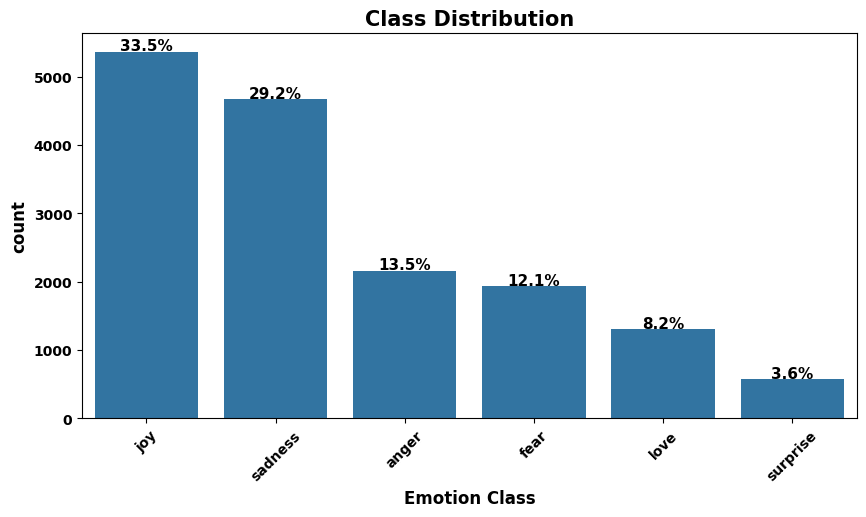

In [ ]:
countplot(10,5,'emotion',15,45,'Emotion Class','Class Distribution')

In [ ]:
# Considering a small set of data as input while debugging
if CFG.debug:
    CFG.epochs = 10
    train = train.sample(frac =.50)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Text Preprocessing </h1></span>

We are doing basic text preprocessing like removing space, unncessary symbols, numbers and so on. To tokenize our sentence, we use a **space tokenizer** to get the tokens of the sentence.

In [ ]:
def preprocess_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')    # add/remove regex as required
    SYMBOLS_RE = re.compile('[^0-9a-z #+_]') # unnecessary symbols
    NUMBERS = re.compile('\d+') # numbers
    STOPWORDS = set(stopwords.words('english')) # stopwords
    lemmatizer = WordNetLemmatizer()  # lemmatizer

    # clean
    text = text.lower() # lowering the text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # removing punc
    text = SYMBOLS_RE.sub('', text) # removing unnecessary symbols
    text = NUMBERS.sub('', text) # removing stop words

    # remove stopwords and lemmatize
    tokens = [word for word in text.split() if word not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

train['tokenized'] = train['text'].apply(preprocess_text)
valid['tokenized'] = valid['text'].apply(preprocess_text)
test['tokenized']  =  test['text'].apply(preprocess_text)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Making the vocabulary </h1></span>

Now to get the token_ids for the tokens, we need to define a vocabulary. A vocabulary is created to map words to numerical indices. This is essential for several reasons:

**Numerical Representation**: Neural networks, including LSTMs, operate on numerical data. Therefore, text data, which is inherently symbolic (consisting of words), needs to be converted into a numerical format. Each unique word is assigned a unique index in the vocabulary.

**Embedding Layer Input**: LSTMs typically operate on word embeddings. An embedding layer maps each word index to a high-dimensional vector (embedding). This layer essentially learns a representation for each word in the vocabulary, and these representations are updated during training. The embedding layer requires a vocabulary to map word indices to corresponding embedding vectors.

**Fixed Input Size**: LSTMs process sequences of fixed length. By using a fixed vocabulary, you establish a consistent way to map words to indices, ensuring that each input sequence has the same length. Padding or truncation can be used to achieve this fixed length.

In [ ]:
def make_vocabulary_from_tokens(tokenized_sentences: pd.Series, min_doc_freq: int = 1,max_doc_freq: int = 1_000_000):

    # Count frequency of each token in dataset
    document_freq = {}
    for tokenized_sentence in tokenized_sentences:
        for token in tokenized_sentence:
            document_freq[token] = document_freq.get(token, 0) + 1

    # Discard tokens with freq < min_doc_freq
    qualified_tokens = {
        token: freq
        for token, freq in document_freq.items()
        if (min_doc_freq < freq < max_doc_freq)
    }

    # Add in token_ids for each token
    vocab = {token: token_id+2 for token_id, token in enumerate(qualified_tokens.keys())}

    # Add special tokens
    vocab['[PAD]'] = 0
    vocab['[UNK]'] = 1

    return vocab, qualified_tokens

vocab, doc_freq = make_vocabulary_from_tokens(train['tokenized'], 3)    # use only train set for this
print(f'{len(vocab)=}')

len(vocab)=2486


In [ ]:
def make_vocabulary_from_tokens(tokenized: pd.Series):
    vocab = set()
    tokenized.apply(lambda tokens: vocab.update(tokens))
    vocab = {token: token_id+2 for token_id, token in enumerate(list(vocab))}
    vocab['[PAD]'] = 0
    vocab['[UNK]'] = 1
    return vocab

vocab = make_vocabulary_from_tokens(train['tokenized'])    # use only train set for this
CFG.vocab_size = len(vocab)
print(f'Total length of the Vocabulary: {len(vocab)}')

Total length of the Vocabulary: 9427


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Tokens to Input Ids </h1></span>

Input IDs are numerical representations of tokens. Each unique token in a dataset is assigned a unique numerical identifier, called its input ID. These input IDs are used as indices to look up corresponding embeddings in the model's embedding layer.

In [ ]:
def tokens_to_input_ids(tokenized_sentence, vocabulary=vocab):
    input_ids = [
        vocabulary.get(token, 1) for token in tokenized_sentence    # assigns UNK token if token not in vocabulary
    ]
    return input_ids

X_train, y_train = train['tokenized'].apply(tokens_to_input_ids), train['label'].to_list()
X_valid, y_valid = valid['tokenized'].apply(tokens_to_input_ids), valid['label'].to_list()
X_test,  y_test  = test['tokenized'].apply(tokens_to_input_ids),  test['label'].to_list()

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Creating Pytorch Dataset </h1></span>

We are creating a pytorch dataset instance. Basically, in deep learning, we need all data-samples in a batch should be should be the **same length**. In NLP, the pad_sequence function, commonly used in frameworks like PyTorch, is essential for handling sequences of variable lengths. It addresses the need for fixed-length input sequences, a requirement for batch processing in neural networks. Sequences of different lengths, prevalent in natural language data, are padded with a special token to ensure uniformity within batches. This step is crucial for maintaining consistent tensor shapes, aligning with the expectations of neural network models, and facilitating efficient batch processing. The pad_sequence function simplifies this padding process, ensuring that shorter sequences are padded appropriately for compatibility with deep learning models.

In [ ]:
class TextDataset(Dataset):
    def __init__(self, input_ids, labels):
        '''
        - Stores tokenized sentences as tensors of input ids according to vocabulary mapping.
        - Label indices are converted to one hot encoding.
        '''
        self.input_ids = pad_sequence([torch.tensor(sequence) for sequence in input_ids], batch_first=True)
        self.labels = nn.functional.one_hot(torch.tensor(labels)).to(torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return [self.input_ids[idx], self.labels[idx]]

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Creating the Model </h1></span>

We are following the same model architecure shown in slide. Basically,

- Initialize the LSTMClassifier, setting the number of LSTM layers, hidden dimensions, vocabulary size, embedding dimensions, and dropout rate.

- Define the embedding layer using nn.Embedding based on the specified vocabulary size and embedding dimensions.

- Configure the LSTM layer using nn.LSTM, with parameters including input and hidden dimensions, the number of layers, and batch-first set to True.

- Implement dropout regularization using nn.Dropout with the specified dropout rate.

- Create a fully connected layer (nn.Linear) for the classification task, with the output size equal to the number of classes.

- In the forward method, apply dropout to the input embeddings, then pass them through the LSTM layer.

- Extract the representation of the last token as the sentence representation from the LSTM output.

- Pass the sentence representation through the fully connected layer to obtain the final logits for classification.

- Return the logits as the output of the forward pass.

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, cfg):
        # Model
        super().__init__()
        self.n_layers = cfg.num_lstm_layers
        self.hidden_dim = cfg.hidden_dim
        # self.embedding = nn.Embedding(cfg.vocab_size, cfg.embedding_dim)

        # Create an embedding matrix from word2vec
        embedding_matrix = torch.zeros((cfg.vocab_size, cfg.embedding_dim))
        for i, word in enumerate(wv.index_to_key):
            if i < cfg.vocab_size:
                embedding_matrix[i] = torch.tensor(wv[word])
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)


        self.lstm = nn.LSTM(
            cfg.embedding_dim, cfg.hidden_dim, num_layers=self.n_layers,
            batch_first=True
        )
        self.dropout = nn.Dropout(cfg.dropout_rate)
        self.fc = nn.Linear(self.hidden_dim, cfg.num_class)

    def forward(self, X_batch):
        embedding = self.dropout(self.embedding(X_batch))
        h, c = torch.randn(self.n_layers, len(X_batch), self.hidden_dim), torch.randn(self.n_layers, len(X_batch), self.hidden_dim)
        output, (h, c) = self.lstm(embedding, (h, c))
        sentence_repr = output[:,-1] # considering the last token repr as the sentence repr
        logits = self.fc(sentence_repr)
        return logits

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Pytorch Code for One Epoch Training </h1></span>

In [ ]:
def get_score(y_trues, y_preds):
    y_predicted = y_preds.argmax(axis=1)  # Convert probabilities to class predictions
    macro_f1 = f1_score(y_trues, y_predicted, average='macro')
    return macro_f1


def train_one_epoch(train_loader, model, optimizer, loss_fn, epoch):
    model.train()
    running_loss = 0
    running_score = 0

    loop = tqdm.tqdm(enumerate(train_loader),
                         total=len(train_loader), leave=False)

    for i, data in loop:
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # compute metrics and store
        score = get_score(labels.argmax(axis=1), outputs)
        running_score += score
        running_loss += loss.item()

        loop.set_description(f"Epoch [{epoch + 1}/{CFG.n_epochs}]")
        loop.set_postfix(loss=running_loss / (i + 1))

    avg_score = float(score / (i + 1))
    avg_loss = float(loss / (i + 1))

    return avg_score, avg_loss


def eval_one_epoch(valid_loader, model, loss_fn):
    # Validate
    model.eval()
    running_vloss = 0
    running_vscore = 0

    with torch.no_grad():
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)

            vscore = get_score(vlabels.argmax(axis=1), voutputs)
            running_vscore += vscore
            running_vloss += vloss

    avg_vscore = float(running_vscore / (i + 1))
    avg_vloss = float(running_vloss / (i + 1))

    return avg_vscore, avg_vloss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Training Loop </h1></span>

In [ ]:
def train_loop(X_train, y_train, X_valid, y_valid, CFG):

    model = LSTMClassifier(CFG) # Initializing the Model

    # Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)

    train_dataset = TextDataset(X_train, y_train)
    valid_dataset = TextDataset(X_valid, y_valid)

    train_loader  = DataLoader(train_dataset,batch_size=CFG.batch_size, shuffle=True)
    valid_loader  = DataLoader(valid_dataset,batch_size=CFG.batch_size, shuffle=False)

    best_score = 0
    train_loss = []; train_score = []
    valid_loss = []; valid_score = []

    for epoch in range(CFG.n_epochs):

        avg_score, avg_loss = train_one_epoch(train_loader, model, optimizer, loss_fn, epoch)

        avg_vscore, avg_vloss = eval_one_epoch(valid_loader, model, loss_fn)

        # Track best performance and save model's state
        if avg_vscore > best_score:
            best_score = avg_vscore
            model_path = f"best_scored_model.pth"
            torch.save(model.state_dict(), model_path)

        print(f"Epoch {epoch+1}: Training Loss = {avg_loss:.4} Training Score = {avg_score:.4f}", end = " & ")
        print(f"Validation Loss = {avg_vloss:.4f} Validation Score = {avg_vscore:.4f}")
        train_loss.append(avg_loss); train_score.append(avg_score)
        valid_loss.append(avg_vloss); valid_score.append(avg_vscore)

    # Plot loss and metric
    fig,(ax1, ax2) = plt.subplots(1, 2)

    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss'); ax1.set_title('training loss')
    ax1.plot(np.arange(len(train_loss)), train_loss, label='training')
    ax1.plot(np.arange(len(valid_loss)), valid_loss, label='validation')
    ax1.legend()

    ax2.set_xlabel('epoch'); ax2.set_ylabel('score'); ax2.set_title('training score')
    ax2.plot(np.arange(len(train_score)), train_score, label='training')
    ax2.plot(np.arange(len(valid_score)), valid_score, label='validation')
    ax2.legend()

    return best_score

Epoch 1: Training Loss = 0.01345 Training Score = 0.0007 & Validation Loss = 1.5838 Validation Score = 0.0892


Epoch 2: Training Loss = 0.01304 Training Score = 0.0007 & Validation Loss = 1.5827 Validation Score = 0.0892


Epoch 3: Training Loss = 0.01168 Training Score = 0.0013 & Validation Loss = 1.5382 Validation Score = 0.1679


Epoch 4: Training Loss = 0.01294 Training Score = 0.0009 & Validation Loss = 1.6140 Validation Score = 0.0892


Epoch 5: Training Loss = 0.01291 Training Score = 0.0006 & Validation Loss = 1.5855 Validation Score = 0.0892


Epoch 6: Training Loss = 0.01208 Training Score = 0.0008 & Validation Loss = 1.5821 Validation Score = 0.0892


Epoch 7: Training Loss = 0.01169 Training Score = 0.0009 & Validation Loss = 1.5826 Validation Score = 0.0892


Epoch 8: Training Loss = 0.01283 Training Score = 0.0006 & Validation Loss = 1.5843 Validation Score = 0.0892


Epoch 9: Training Loss = 0.01213 Training Score = 0.0008 & Validation Loss = 1.5814 Validation Score = 0.0892


Epoch 10: Training Loss = 0.01253 Training Score = 0.0007 & Validation Loss = 1.5859 Validation Score = 0.0892


Epoch 11: Training Loss = 0.0121 Training Score = 0.0008 & Validation Loss = 1.5808 Validation Score = 0.0892


Epoch 12: Training Loss = 0.01164 Training Score = 0.0010 & Validation Loss = 1.5882 Validation Score = 0.0900


Epoch 13: Training Loss = 0.01211 Training Score = 0.0008 & Validation Loss = 1.5824 Validation Score = 0.0892


Epoch 14: Training Loss = 0.01393 Training Score = 0.0005 & Validation Loss = 1.5828 Validation Score = 0.0892


Epoch 15: Training Loss = 0.01204 Training Score = 0.0007 & Validation Loss = 1.5830 Validation Score = 0.0891


Epoch 16: Training Loss = 0.01259 Training Score = 0.0007 & Validation Loss = 1.5847 Validation Score = 0.0896


Epoch 17: Training Loss = 0.01297 Training Score = 0.0007 & Validation Loss = 1.5837 Validation Score = 0.0896


Epoch 18: Training Loss = 0.01286 Training Score = 0.0007 & Validation Loss = 1.5860 Validation Score = 0.0902


Epoch 19: Training Loss = 0.01193 Training Score = 0.0008 & Validation Loss = 1.5887 Validation Score = 0.0732


Epoch 20: Training Loss = 0.0134 Training Score = 0.0007 & Validation Loss = 1.5831 Validation Score = 0.0907


Epoch 21: Training Loss = 0.01083 Training Score = 0.0012 & Validation Loss = 1.3599 Validation Score = 0.1905


Epoch 22: Training Loss = 0.008989 Training Score = 0.0028 & Validation Loss = 1.2329 Validation Score = 0.2583


Epoch 23: Training Loss = 0.006445 Training Score = 0.0043 & Validation Loss = 1.1102 Validation Score = 0.4123


Epoch 24: Training Loss = 0.006545 Training Score = 0.0037 & Validation Loss = 1.1673 Validation Score = 0.3702


Epoch 25: Training Loss = 0.005826 Training Score = 0.0045 & Validation Loss = 1.1427 Validation Score = 0.4508


Epoch 26: Training Loss = 0.006453 Training Score = 0.0054 & Validation Loss = 1.0266 Validation Score = 0.5364


Epoch 27: Training Loss = 0.005281 Training Score = 0.0053 & Validation Loss = 0.9242 Validation Score = 0.6597


Epoch 28: Training Loss = 0.004906 Training Score = 0.0066 & Validation Loss = 0.8945 Validation Score = 0.6919


Epoch 29: Training Loss = 0.003753 Training Score = 0.0074 & Validation Loss = 0.8317 Validation Score = 0.7393


Epoch 30: Training Loss = 0.003253 Training Score = 0.0072 & Validation Loss = 0.7106 Validation Score = 0.7603


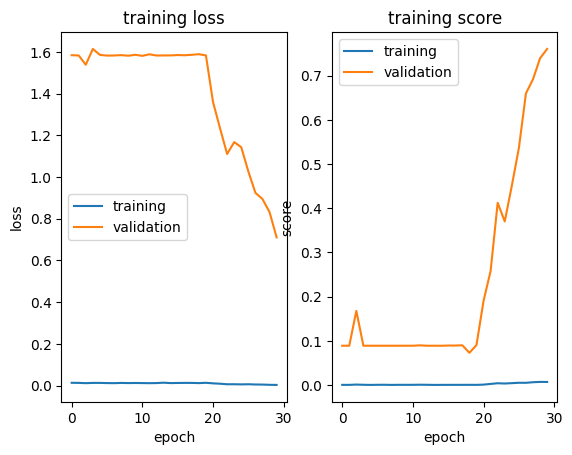

In [ ]:
# ====================================================
# the training
# ====================================================

if __name__ == '__main__':
    best_score = train_loop(X_train, y_train, X_valid, y_valid, CFG)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Prediction on Test Dataset & Evaluation </h1></span>

In [ ]:
def test_model(X, y, model, label_names):
    model.eval()

    test_dataset = TextDataset(X, y)
    test_loader  = DataLoader(test_dataset,batch_size=CFG.batch_size, shuffle=False)

    y_preds = []
    with torch.no_grad():
        for i, data in tqdm.tqdm(enumerate(test_loader)):
            inputs, labels = data
            outputs = model(inputs)
            y_preds.append(outputs.argmax(1))

    y_preds = torch.cat(y_preds)

    print(classification_report(y, y_preds, target_names=label_names))
    ConfusionMatrixDisplay.from_predictions(y, y_preds, display_labels=label_names)

    return y_preds

<ipython-input-52-0b1ca7c238b3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path) # loading the saved model
32it [00:00, 55.03it/s]


              precision    recall  f1-score   support

     sadness       0.71      0.88      0.78       581
         joy       0.82      0.86      0.84       275
        fear       0.69      0.83      0.76       159
        love       0.67      0.61      0.63        66
       anger       0.82      0.76      0.79       224
    surprise       0.92      0.70      0.79       695

    accuracy                           0.79      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.81      0.79      0.79      2000



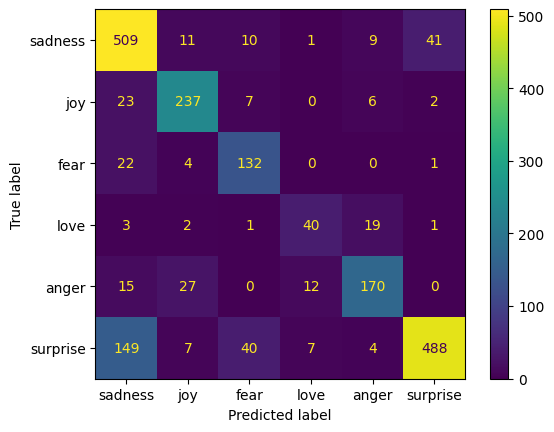

In [ ]:
label_names = train["emotion"].unique()
model = LSTMClassifier(CFG)
model_path = f"best_scored_model.pth"
state = torch.load(model_path) # loading the saved model

model.load_state_dict(state)
test_set_predictions = test_model(X_test, y_test, model, label_names)